In [180]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.contrib.keras as keras
from tensorflow.examples.tutorials.mnist import input_data
import os
from matplotlib import pyplot as plt
import pathnet
from tqdm import tqdm

In [2]:
path=os.getcwd()

In [3]:
path

'/data/home/t1110557/My_Project/playground'

In [4]:
##MNIST DATA loading..
mnist = input_data.read_data_sets('/data/home/t1110557/My_Project/jupyter_notebook/study/MNIST_data',one_hot=True)

Extracting /data/home/t1110557/My_Project/jupyter_notebook/study/MNIST_data/train-images-idx3-ubyte.gz
Extracting /data/home/t1110557/My_Project/jupyter_notebook/study/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /data/home/t1110557/My_Project/jupyter_notebook/study/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /data/home/t1110557/My_Project/jupyter_notebook/study/MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
#train data loading..
total_tr_data, total_tr_label = mnist.train.next_batch(mnist.train._num_examples)

In [6]:
# Gathering a1 Data(label==1)
tr_data_a1=total_tr_data[(total_tr_label[:,1]==1.0)];
for i in range(len(tr_data_a1)):
    for j in range(len(tr_data_a1[0])):
        rand_num=np.random.rand();
        if(rand_num>=0.7):
            #generate noise
            tr_data_a1[i,j]=np.minimum(tr_data_a1[i,j]+rand_num,1.0);

In [7]:
# Gathering a2 Data(label==3)
tr_data_a2=total_tr_data[(total_tr_label[:,3]==1.0)];
for i in range(len(tr_data_a2)):
    for j in range(len(tr_data_a2[0])):
        rand_num=np.random.rand();
        if(rand_num>=0.7):
            #generate noise
            tr_data_a2[i,j]=np.minimum(tr_data_a2[i,j]+rand_num,1.0);

In [8]:
# Gathering b1 Data(label==1)
tr_data_b1=total_tr_data[(total_tr_label[:,1]==1.0)];
for i in range(len(tr_data_b1)):
    for j in range(len(tr_data_b1[0])):
        rand_num=np.random.rand();
        if(rand_num>=0.7):
            #generate noise
            tr_data_b1[i,j]=np.minimum(tr_data_b1[i,j]+rand_num,1.0);

In [9]:
# Gathering b2 Data(label==2)
tr_data_b2=total_tr_data[(total_tr_label[:,2]==1.0)];
for i in range(len(tr_data_b2)):
    for j in range(len(tr_data_b2[0])):
        rand_num=np.random.rand();
        if(rand_num>=0.7):
            #generate noise
            tr_data_b2[i,j]=np.minimum(tr_data_b2[i,j]+rand_num,1.0);

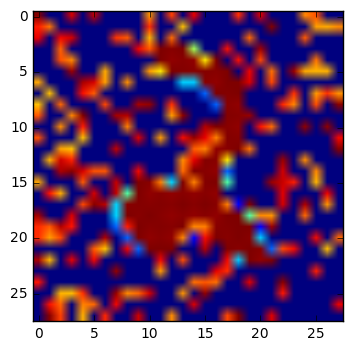

In [10]:
plt.imshow(tr_data_b2[100].reshape(28,28))
plt.show()

In [11]:
#Generate train data set 1
tr_data1=np.append(tr_data_a1,tr_data_a2,axis=0);
tr_label1=np.zeros((len(tr_data1),2),dtype=float);
for i in range(len(tr_data1)):
    if(i<len(tr_data_a1)):
        tr_label1[i,0]=1.0;
    else:
        tr_label1[i,1]=1.0;

In [12]:
#Generate train data set 2
tr_data2=np.append(tr_data_b1,tr_data_b2,axis=0);
tr_label2=np.zeros((len(tr_data2),2),dtype=float);
for i in range(len(tr_data2)):
    if(i<len(tr_data_b1)):
        tr_label2[i,0]=1.0;
    else:
        tr_label2[i,1]=1.0;

In [13]:
##Generate session
sess = tf.InteractiveSession()

In [14]:
#Define placeholder
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, 784], name='x-input')
    y_ = tf.placeholder(tf.float32, [None, 2], name='y-input')

with tf.name_scope('input_reshape'):
    image_shaped_input = tf.reshape(x, [-1, 28, 28, 1])
    tf.summary.image('input', image_shaped_input, 2)

In [15]:
#Define hyperparameters
L = 3  #number of layer
M = 10 #module of each layer
N = 4 # number of active module for each layer
filt = 20 # number of neuron in each module
input_shape = 28*28
learning_rate = 0.05
candi = 64  # number of candidate gene
B = 2
max_steps = 10000
epoches=50
batch_num = 16
T = 50 # the number of epoch per each geopath

In [16]:
#Initilize geopath graph
geopath = pathnet.geopath_initializer(L,M);

In [17]:
geopath.shape

(3, 10)

In [18]:
# fixed weights list (save the optimal geopath)
fixed_list=np.ones((L,M),dtype=str);
for i in range(L):
    for j in range(M):
        fixed_list[i,j]='0';    

In [19]:
fixed_list[0,0]

'0'

In [20]:
#Define hidden layer
weights_list=np.zeros((L,M),dtype=object);
biases_list=np.zeros((L,M),dtype=object);

In [21]:
weights_list

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=object)

In [22]:
for i in range(L):
    for j in range(M):
        if(i==0):
            weights_list[i,j]=pathnet.module_weight_variable([input_shape,filt]);
            biases_list[i,j]=pathnet.module_bias_variable([filt]);
        else:
            weights_list[i,j]=pathnet.module_weight_variable([filt,filt]);
            biases_list[i,j]=pathnet.module_bias_variable([filt]);

In [23]:
weights_list.shape

(3, 10)

In [24]:
weights_list[0][0]

[<tf.Variable 'Variable_30:0' shape=(784, 20) dtype=float32_ref>]

In [25]:
for i in range(L):
    layer_modules_list=np.zeros(M,dtype=object);
    for j in range(M):
        if(i==0):
            layer_modules_list[j]=pathnet.module(x, weights_list[i,j], biases_list[i,j], 'layer'+str(i+1)+"_"+str(j+1))*geopath[i,j];
        else:
            layer_modules_list[j]=pathnet.module2(j,net, weights_list[i,j], biases_list[i,j], 'layer'+str(i+1)+"_"+str(j+1))*geopath[i,j];
    net=np.sum(layer_modules_list)/M

In [26]:
# Output Layer
output_weights=pathnet.module_weight_variable([filt,2])
output_biases=pathnet.module_bias_variable([2])
y = pathnet.nn_layer(net,output_weights,output_biases,'output_layer')

In [27]:
# Calculate Cross Entropy
with tf.name_scope('cross_entropy'):
    diff = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
    with tf.name_scope('total'):
        cross_entropy = tf.reduce_mean(diff)
    tf.summary.scalar('cross_entropy', cross_entropy)

In [28]:
# Need to learn variables(parater update list)
var_list_to_learn=[]+output_weights+output_biases;
for i in range(L):
    for j in range(M):
        if (fixed_list[i,j]=='0'):
            var_list_to_learn+=weights_list[i,j]+biases_list[i,j];

In [29]:
# GradientDescent 
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy,var_list=var_list_to_learn);

In [30]:
# Accuracy 
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

In [31]:
##Generate session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.05
sess = tf.InteractiveSession(config=config)

merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(os.getcwd() + '/train2', sess.graph)
test_writer = tf.summary.FileWriter(os.getcwd() + '/test2')
tf.global_variables_initializer().run()

In [32]:
# Generating randomly geopath(geopath gene list)
geopath_set=np.zeros(candi,dtype=object);
for i in range(candi):
    geopath_set[i]=pathnet.get_geopath(L,M,N);

In [34]:
# parameters placeholders and ops 
var_update_ops=np.zeros(len(var_list_to_learn),dtype=object)
var_update_placeholders=np.zeros(len(var_list_to_learn),dtype=object)
for i in range(len(var_list_to_learn)):
    var_update_placeholders[i]=tf.placeholder(var_list_to_learn[i].dtype,shape=var_list_to_learn[i].get_shape())
    var_update_ops[i]=var_list_to_learn[i].assign(var_update_placeholders[i])

In [35]:
# geopathes placeholders and ops 
geopath_update_ops=np.zeros((geopath.shape[0],geopath.shape[1]),dtype=object);
geopath_update_placeholders=np.zeros((geopath.shape[0],geopath.shape[1]),dtype=object);
for i in range(geopath.shape[0]):
    for j in range(geopath.shape[1]):
        geopath_update_placeholders[i,j]=tf.placeholder(geopath[i,j].dtype,shape=geopath[i,j].get_shape());
        geopath_update_ops[i,j]=geopath[i,j].assign(geopath_update_placeholders[i,j]);

In [81]:
def train(data,label):
    acc_geo=np.zeros(B,dtype=float)
    summary_geo=np.zeros(B,dtype=object)
    for i in range(max_steps):
        # Select Candidates to Tournament
        compet_idx = np.arange(candi)
        np.random.shuffle(compet_idx)
        compet_idx = compet_idx[:B]
        
        #learning & evaluateing
        for j in range(len(compet_idx)):
            #shuffling data
            idx = np.arange(len(data))
            np.random.shuffle(idx)
            data = data[idx]
            label = label[idx]
            #insert candidate
            pathnet.geopath_insert(sess,geopath_update_placeholders,geopath_update_ops,geopath_set[compet_idx[j]],L,M)
            acc_geo_tr=0
            for k in range(T):
                summary_geo_tr, _, acc_geo_tmp = sess.run([merged, train_step,accuracy], feed_dict={x:data[k*batch_num:(k+1)*batch_num,:],y_:label[k*batch_num:(k+1)*batch_num,:]})
                acc_geo_tr+=acc_geo_tmp
            acc_geo[j] = acc_geo_tr/T
            summary_geo[j] = summary_geo_tr
        
        #Tournament
        winner_idx = np.argmax(acc_geo)
        acc = acc_geo[winner_idx]
        summary = summary_geo[winner_idx]
        
        # Copy and Mutation
        for j in range(len(compet_idx)):
            if(j!=winner_idx):
                geopath_set[compet_idx[j]]=np.copy(geopath_set[compet_idx[winner_idx]])
                geopath_set[compet_idx[j]]=pathnet.mutation(geopath_set[compet_idx[j]],L,M,N)
        train_writer.add_summary(summary, i)
        if(i %10 ==0):
            print('Training Accuracy at step %s: %s' % (i, acc))
        
        if(acc >= 0.99):
            print('Learning Done!!');
            print('Optimal Path is as followed.');
            print(geopath_set[compet_idx[winner_idx]]);
            task1_optimal_path=geopath_set[compet_idx[winner_idx]];
            break;
    return task1_optimal_path

In [82]:
task1_optimal_path = train(data=tr_data1,label=tr_label1)

Training Accuracy at step 0: 0.54375
Training Accuracy at step 10: 0.6625
Training Accuracy at step 20: 0.87375
Training Accuracy at step 30: 0.96375
Training Accuracy at step 40: 0.9875
Training Accuracy at step 50: 0.9875
Training Accuracy at step 60: 0.97375
Training Accuracy at step 70: 0.9825
Learning Done!!
Optimal Path is as followed.
[[ 1.  0.  1.  0.  0.  1.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  1.  0.  1.  0.]
 [ 1.  0.  1.  1.  0.  0.  1.  0.  0.  0.]]


In [83]:
task1_optimal_path

array([[ 1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.],
       [ 1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.]])

In [56]:
# Fix task1 Optimal Path
for i in range(L):
    for j in range(M):
        if(task1_optimal_path[i,j]==1.0):
            fixed_list[i,j]='1';

In [58]:
# Get variables of fixed list
var_list_to_fix=[];
#var_list_to_fix=[]+output_weights+output_biases;
for i in range(L):
    for j in range(M):
        if(fixed_list[i,j]=='1'):
            var_list_to_fix+=weights_list[i,j]+biases_list[i,j];
var_list_fix=pathnet.parameters_backup(var_list_to_fix);

In [181]:
#predict data
def pred(data,optimal_path):
    predict = np.asarray([])
    pathnet.geopath_insert(sess,geopath_update_placeholders,geopath_update_ops,optimal_path,L,M)
    valid_batch = int(np.shape(data)[0]/batch_num)
    for k in tqdm(range(valid_batch)):
        pred_tmp = sess.run(tf.nn.softmax(y), feed_dict={x:data[k*batch_num:(k+1)*batch_num,:]})
        if k ==0:
            predict = pred_tmp
        else:
            predict = np.append(predict,pred_tmp,axis=0)
    return predict

In [182]:
pred_label = pred(tr_data1,task1_optimal_path)

100%|██████████| 738/738 [01:01<00:00, 11.74it/s]


In [183]:
pred_label

array([[  9.90715504e-01,   9.28453077e-03],
       [  9.85603809e-01,   1.43961506e-02],
       [  9.89585578e-01,   1.04144206e-02],
       ..., 
       [  1.46804568e-05,   9.99985337e-01],
       [  2.26616889e-04,   9.99773443e-01],
       [  7.26444996e-04,   9.99273598e-01]], dtype=float32)

In [154]:
valid_batch

738

In [174]:
int(np.shape(tr_data1)[0]/batch_num)

738

In [134]:
predict

array([[ 0.9907155 ,  0.00928453],
       [ 0.98560381,  0.01439615],
       [ 0.98958558,  0.01041442],
       ..., 
       [ 0.99046445,  0.00953551],
       [ 0.99457282,  0.00542721],
       [ 0.98889685,  0.01110315]], dtype=float32)

In [143]:
tr_label1.shape[0]

11817

In [136]:
tr_label1[10000:11000]

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [184]:
fixed_list

array([['0', '0', '0', '1', '1', '0', '1', '0', '0', '1'],
       ['1', '1', '0', '1', '0', '1', '0', '0', '0', '0'],
       ['0', '0', '1', '0', '0', '0', '1', '0', '1', '1']],
      dtype='<U1')